# All Imports

In [1]:
# Cell 1: Import Required Libraries
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import numpy as np
from PIL import Image
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import random
import pandas as pd
import gc
from peft import get_peft_model, LoraConfig, TaskType
from collections import Counter
import pickle
import math
from sacrebleu import BLEU
import sentencepiece as spm
import torchvision
from scipy import linalg

# For Hugging Face components
from transformers import (
    AutoTokenizer, # To get a pre-trained tokenizer (e.g., for mBART)
    MBartForConditionalGeneration, # The mBART model
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq
)
from datasets import load_dataset, Dataset as HFDataset # To handle the dataset efficiently

# For evaluation metrics
import sacrebleu # For BLEU score calculation
import evaluate
from evaluate import load # To load metrics like BLEU

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

d:\Python 3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU: NVIDIA GeForce RTX 5060
Available GPU memory: 8.55 GB


# **Question 1**

In [2]:
# Hyperparameters and Configuration
class Config:
    # Paths
    dataset_path = 'train'  # Update this path
    checkpoint_dir = 'checkpoints'
    sample_dir = 'samples'
    
    # Training hyperparameters
    epochs = 20
    batch_size = 1  # CycleGAN typically uses batch_size=1
    learning_rate = 0.0002
    beta1 = 0.5  # Adam optimizer beta1
    beta2 = 0.999  # Adam optimizer beta2
    
    # Image parameters
    img_height = 256
    img_width = 256
    channels = 3
    
    # Loss weights
    lambda_cycle = 10.0  # Cycle consistency loss weight
    lambda_identity = 0.5  # Identity loss weight (0.5 * lambda_cycle)
    
    # Learning rate decay
    decay_epoch = 10  # Epoch to start linearly decaying learning rate to 0
    
    # Other settings
    num_workers = 0
    save_interval = 5  # Save checkpoints every N epochs
    sample_interval = 100  # Save sample images every N batches
    resume_training = False  # Set to True to resume from checkpoint
    resume_epoch = 0  # Epoch to resume from
    
config = Config()

# Create necessary directories
os.makedirs(config.checkpoint_dir, exist_ok=True)
os.makedirs(config.sample_dir, exist_ok=True)

print("Configuration loaded successfully!")
print(f"Image size: {config.img_height}x{config.img_width}")
print(f"Batch size: {config.batch_size}")
print(f"Learning rate: {config.learning_rate}")

Configuration loaded successfully!
Image size: 256x256
Batch size: 1
Learning rate: 0.0002


In [11]:
# Dataset Class
class FaceSketchDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='train', max_samples=None): # ADDED max_samples
        """
        Args:
            root_dir (string): Directory with all the images
            transform (callable, optional): Optional transform to be applied on a sample
            mode (string): 'train' or 'test'
            max_samples (int, optional): Maximum number of files to load from each directory.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        self.max_samples = max_samples # Store the limit
        
        self.photos_dir = os.path.join(root_dir, 'photos')
        self.sketches_dir = os.path.join(root_dir, 'sketches')
        
        # Get all image files
        self.photo_files = sorted(glob.glob(os.path.join(self.photos_dir, '*.*')))
        self.sketch_files = sorted(glob.glob(os.path.join(self.sketches_dir, '*.*')))
        
        # --- MODIFICATION START ---
        # Limit the number of files if max_samples is provided
        if self.max_samples is not None:
            self.photo_files = self.photo_files[:self.max_samples]
            self.sketch_files = self.sketch_files[:self.max_samples]
        # --- MODIFICATION END ---
        
        print(f"Found {len(self.photo_files)} photos and {len(self.sketch_files)} sketches")
        
        # For unpaired training, we can have different numbers
        self.length = max(len(self.photo_files), len(self.sketch_files))
    
    def __len__(self):
        return self.length
    
    # __getitem__ remains the same...
    def __getitem__(self, idx):
        # Use modulo to handle different dataset sizes
        photo_idx = idx % len(self.photo_files)
        sketch_idx = idx % len(self.sketch_files)
        
        # Load images
        photo = Image.open(self.photo_files[photo_idx]).convert('RGB')
        sketch = Image.open(self.sketch_files[sketch_idx]).convert('RGB')
        
        # Apply transforms
        if self.transform:
            photo = self.transform(photo)
            sketch = self.transform(sketch)
        
        return {'photo': photo, 'sketch': sketch}

In [3]:
# Generator Architecture (ResNet-based)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, kernel_size=3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, kernel_size=3),
            nn.InstanceNorm2d(in_channels)
        )
    
    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, num_residual_blocks=9):
        super(Generator, self).__init__()
        
        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        # Downsampling
        in_channels = 64
        out_channels = in_channels * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels
            out_channels = in_channels * 2
        
        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(in_channels)]
        
        # Upsampling
        out_channels = in_channels // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, 
                                   padding=1, output_padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels
            out_channels = in_channels // 2
        
        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_channels, kernel_size=7),
            nn.Tanh()
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)


# Test generator
print("Testing Generator architecture...")
gen = Generator().to(device)
test_input = torch.randn(1, 3, 256, 256).to(device)
test_output = gen(test_input)
print(f"Generator input shape: {test_input.shape}")
print(f"Generator output shape: {test_output.shape}")
print(f"Generator parameters: {sum(p.numel() for p in gen.parameters()):,}")
del gen, test_input, test_output
torch.cuda.empty_cache()
print("Generator architecture verified!")

Testing Generator architecture...
Generator input shape: torch.Size([1, 3, 256, 256])
Generator output shape: torch.Size([1, 3, 256, 256])
Generator parameters: 11,378,179
Generator architecture verified!


In [4]:
# Discriminator Architecture (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        
        def discriminator_block(in_channels, out_channels, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(input_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1)
        )
    
    def forward(self, x):
        return self.model(x)


# Test discriminator
print("Testing Discriminator architecture...")
disc = Discriminator().to(device)
test_input = torch.randn(1, 3, 256, 256).to(device)
test_output = disc(test_input)
print(f"Discriminator input shape: {test_input.shape}")
print(f"Discriminator output shape: {test_output.shape}")
print(f"Discriminator parameters: {sum(p.numel() for p in disc.parameters()):,}")
del disc, test_input, test_output
torch.cuda.empty_cache()
print("Discriminator architecture verified!")

Testing Discriminator architecture...
Discriminator input shape: torch.Size([1, 3, 256, 256])
Discriminator output shape: torch.Size([1, 1, 16, 16])
Discriminator parameters: 2,764,737
Discriminator architecture verified!


In [5]:
# Loss Functions and Utilities
class ReplayBuffer:
    """
    Buffer to store previously generated images
    Helps stabilize training by showing discriminator a history of generated images
    """
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []
    
    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)


class LambdaLR:
    """
    Learning rate scheduler
    Keeps learning rate constant for first half of training, then linearly decays to 0
    """
    def __init__(self, epochs, offset, decay_start_epoch):
        self.epochs = epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
    
    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.epochs - self.decay_start_epoch)


def weights_init_normal(m):
    """Initialize network weights"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)


def save_checkpoint(epoch, G_AB, G_BA, D_A, D_B, optimizer_G, optimizer_D_A, optimizer_D_B, checkpoint_dir):
    """Save model checkpoints"""
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'G_AB_state_dict': G_AB.state_dict(),
        'G_BA_state_dict': G_BA.state_dict(),
        'D_A_state_dict': D_A.state_dict(),
        'D_B_state_dict': D_B.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_A_state_dict': optimizer_D_A.state_dict(),
        'optimizer_D_B_state_dict': optimizer_D_B.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")


def load_checkpoint(checkpoint_path, G_AB, G_BA, D_A, D_B, optimizer_G, optimizer_D_A, optimizer_D_B):
    """Load model checkpoints"""
    checkpoint = torch.load(checkpoint_path)
    G_AB.load_state_dict(checkpoint['G_AB_state_dict'])
    G_BA.load_state_dict(checkpoint['G_BA_state_dict'])
    D_A.load_state_dict(checkpoint['D_A_state_dict'])
    D_B.load_state_dict(checkpoint['D_B_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D_A.load_state_dict(checkpoint['optimizer_D_A_state_dict'])
    optimizer_D_B.load_state_dict(checkpoint['optimizer_D_B_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Checkpoint loaded from epoch {epoch}")
    return epoch


print("Loss functions and utilities defined successfully!")

Loss functions and utilities defined successfully!


In [6]:
# Initialize Models and Optimizers
print("Initializing CycleGAN models...")

# Initialize generators
# G_AB: Photo -> Sketch (A to B)
# G_BA: Sketch -> Photo (B to A)
G_AB = Generator(input_channels=3, output_channels=3).to(device)
G_BA = Generator(input_channels=3, output_channels=3).to(device)

# Initialize discriminators
# D_A: Discriminates photos
# D_B: Discriminates sketches
D_A = Discriminator(input_channels=3).to(device)
D_B = Discriminator(input_channels=3).to(device)

# Apply weight initialization
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

# Loss functions
criterion_GAN = nn.MSELoss()  # LSGAN loss
criterion_cycle = nn.L1Loss()  # Cycle consistency loss
criterion_identity = nn.L1Loss()  # Identity loss

# Optimizers
optimizer_G = optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()),
    lr=config.learning_rate,
    betas=(config.beta1, config.beta2)
)

optimizer_D_A = optim.Adam(
    D_A.parameters(),
    lr=config.learning_rate,
    betas=(config.beta1, config.beta2)
)

optimizer_D_B = optim.Adam(
    D_B.parameters(),
    lr=config.learning_rate,
    betas=(config.beta1, config.beta2)
)

# Learning rate schedulers
lr_scheduler_G = optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=LambdaLR(config.epochs, 0, config.decay_epoch).step
)

lr_scheduler_D_A = optim.lr_scheduler.LambdaLR(
    optimizer_D_A,
    lr_lambda=LambdaLR(config.epochs, 0, config.decay_epoch).step
)

lr_scheduler_D_B = optim.lr_scheduler.LambdaLR(
    optimizer_D_B,
    lr_lambda=LambdaLR(config.epochs, 0, config.decay_epoch).step
)

# Replay buffers
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Resume from checkpoint if specified
start_epoch = 0
if config.resume_training and config.resume_epoch > 0:
    checkpoint_path = os.path.join(config.checkpoint_dir, f'checkpoint_epoch_{config.resume_epoch}.pth')
    if os.path.exists(checkpoint_path):
        start_epoch = load_checkpoint(
            checkpoint_path, G_AB, G_BA, D_A, D_B,
            optimizer_G, optimizer_D_A, optimizer_D_B
        )
        # Update schedulers
        for _ in range(start_epoch):
            lr_scheduler_G.step()
            lr_scheduler_D_A.step()
            lr_scheduler_D_B.step()
    else:
        print(f"Checkpoint not found: {checkpoint_path}")
        print("Starting training from scratch...")

print("\nModel Summary:")
print(f"Generator (G_AB) parameters: {sum(p.numel() for p in G_AB.parameters()):,}")
print(f"Generator (G_BA) parameters: {sum(p.numel() for p in G_BA.parameters()):,}")
print(f"Discriminator (D_A) parameters: {sum(p.numel() for p in D_A.parameters()):,}")
print(f"Discriminator (D_B) parameters: {sum(p.numel() for p in D_B.parameters()):,}")
print(f"\nTotal parameters: {sum(p.numel() for p in G_AB.parameters()) + sum(p.numel() for p in G_BA.parameters()) + sum(p.numel() for p in D_A.parameters()) + sum(p.numel() for p in D_B.parameters()):,}")
print(f"\nStarting from epoch: {start_epoch}")
print("Models initialized successfully!")

Initializing CycleGAN models...

Model Summary:
Generator (G_AB) parameters: 11,378,179
Generator (G_BA) parameters: 11,378,179
Discriminator (D_A) parameters: 2,764,737
Discriminator (D_B) parameters: 2,764,737

Total parameters: 28,285,832

Starting from epoch: 0
Models initialized successfully!


Loading dataset...
Found 2000 photos and 2000 sketches

Dataset loaded successfully!
Training samples: 2000
Number of batches: 2000
Batch size: 1

Visualizing sample data...


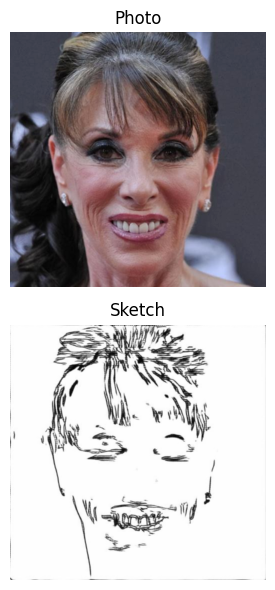

Sample visualization saved!


In [17]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((config.img_height, config.img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define test transformations (without random augmentations)
test_transform = transforms.Compose([
    transforms.Resize((config.img_height, config.img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load Dataset
print("Loading dataset...")

# Create dataset
train_dataset = FaceSketchDataset(
    root_dir=config.dataset_path,
    transform=transform,
    max_samples=2000,
    mode='train'
)

# Create dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True
)

print(f"\nDataset loaded successfully!")
print(f"Training samples: {len(train_dataset)}")
print(f"Number of batches: {len(train_loader)}")
print(f"Batch size: {config.batch_size}")

# Visualize some samples
print("\nVisualizing sample data...")
sample_batch = next(iter(train_loader))
photos = sample_batch['photo']
sketches = sample_batch['sketch']

fig, axes = plt.subplots(2, min(4, config.batch_size), figsize=(12, 6))
if config.batch_size == 1:
    axes = axes.reshape(2, 1)

for i in range(min(4, config.batch_size)):
    # Denormalize images for visualization
    photo = photos[i].cpu().numpy().transpose(1, 2, 0)
    photo = (photo * 0.5 + 0.5)  # Denormalize from [-1, 1] to [0, 1]
    
    sketch = sketches[i].cpu().numpy().transpose(1, 2, 0)
    sketch = (sketch * 0.5 + 0.5)
    
    axes[0, i].imshow(photo)
    axes[0, i].set_title('Photo')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(sketch)
    axes[1, i].set_title('Sketch')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(config.sample_dir, 'dataset_samples.png'))
plt.show()

print("Sample visualization saved!")

In [18]:
# Training Loop
def train_cyclegan():
    """Main training loop for CycleGAN"""
    
    print("\n" + "="*80)
    print("STARTING CYCLEGAN TRAINING")
    print("="*80 + "\n")
    
    # Training history
    history = {
        'G_loss': [],
        'D_A_loss': [],
        'D_B_loss': [],
        'cycle_loss': [],
        'identity_loss': []
    }
    
    for epoch in range(start_epoch, config.epochs):
        epoch_start_time = torch.cuda.Event(enable_timing=True)
        epoch_end_time = torch.cuda.Event(enable_timing=True)
        epoch_start_time.record()
        
        # Training metrics
        G_losses = []
        D_A_losses = []
        D_B_losses = []
        cycle_losses = []
        identity_losses = []
        
        # Progress bar
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.epochs}')
        
        for i, batch in enumerate(pbar):
            # Get real images
            real_A = batch['photo'].to(device)  # Real photos
            real_B = batch['sketch'].to(device)  # Real sketches
            
            # Adversarial ground truths
            valid = torch.ones((real_A.size(0), 1, 16, 16), requires_grad=False).to(device)
            fake = torch.zeros((real_A.size(0), 1, 16, 16), requires_grad=False).to(device)
            
            # ==================
            # Train Generators
            # ==================
            G_AB.train()
            G_BA.train()
            optimizer_G.zero_grad()
            
            # Identity loss
            # G_BA should be identity if real_A is fed: ||G_BA(A) - A||
            loss_id_A = criterion_identity(G_BA(real_A), real_A)
            # G_AB should be identity if real_B is fed: ||G_AB(B) - B||
            loss_id_B = criterion_identity(G_AB(real_B), real_B)
            
            loss_identity = (loss_id_A + loss_id_B) / 2
            
            # GAN loss
            fake_B = G_AB(real_A)  # Photo -> Sketch
            pred_fake = D_B(fake_B)
            loss_GAN_AB = criterion_GAN(pred_fake, valid)
            
            fake_A = G_BA(real_B)  # Sketch -> Photo
            pred_fake = D_A(fake_A)
            loss_GAN_BA = criterion_GAN(pred_fake, valid)
            
            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
            
            # Cycle consistency loss
            recov_A = G_BA(fake_B)  # Photo -> Sketch -> Photo
            loss_cycle_A = criterion_cycle(recov_A, real_A)
            
            recov_B = G_AB(fake_A)  # Sketch -> Photo -> Sketch
            loss_cycle_B = criterion_cycle(recov_B, real_B)
            
            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
            
            # Total generator loss
            loss_G = loss_GAN + \
                     config.lambda_cycle * loss_cycle + \
                     config.lambda_identity * loss_identity
            
            loss_G.backward()
            optimizer_G.step()
            
            # ========================
            # Train Discriminator A
            # ========================
            optimizer_D_A.zero_grad()
            
            # Real loss
            pred_real = D_A(real_A)
            loss_D_real = criterion_GAN(pred_real, valid)
            
            # Fake loss (using replay buffer)
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)
            pred_fake = D_A(fake_A_.detach())
            loss_D_fake = criterion_GAN(pred_fake, fake)
            
            # Total discriminator A loss
            loss_D_A = (loss_D_real + loss_D_fake) / 2
            
            loss_D_A.backward()
            optimizer_D_A.step()
            
            # ========================
            # Train Discriminator B
            # ========================
            optimizer_D_B.zero_grad()
            
            # Real loss
            pred_real = D_B(real_B)
            loss_D_real = criterion_GAN(pred_real, valid)
            
            # Fake loss (using replay buffer)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            pred_fake = D_B(fake_B_.detach())
            loss_D_fake = criterion_GAN(pred_fake, fake)
            
            # Total discriminator B loss
            loss_D_B = (loss_D_real + loss_D_fake) / 2
            
            loss_D_B.backward()
            optimizer_D_B.step()
            
            # ==================
            # Log Progress
            # ==================
            G_losses.append(loss_G.item())
            D_A_losses.append(loss_D_A.item())
            D_B_losses.append(loss_D_B.item())
            cycle_losses.append(loss_cycle.item())
            identity_losses.append(loss_identity.item())
            
            # Update progress bar
            pbar.set_postfix({
                'G': f'{loss_G.item():.4f}',
                'D_A': f'{loss_D_A.item():.4f}',
                'D_B': f'{loss_D_B.item():.4f}',
                'Cycle': f'{loss_cycle.item():.4f}'
            })
            
            # Save sample images
            if i % config.sample_interval == 0:
                with torch.no_grad():
                    G_AB.eval()
                    G_BA.eval()
                    
                    # Generate a grid of samples
                    imgs = torch.cat([
                        real_A.data[:1],
                        fake_B.data[:1],
                        recov_A.data[:1],
                        real_B.data[:1],
                        fake_A.data[:1],
                        recov_B.data[:1]
                    ], 0)
                    
                    save_image(
                        imgs,
                        os.path.join(config.sample_dir, f'epoch_{epoch+1}_batch_{i}.png'),
                        nrow=3,
                        normalize=True
                    )
        
        # Epoch statistics
        epoch_end_time.record()
        torch.cuda.synchronize()
        epoch_time = epoch_start_time.elapsed_time(epoch_end_time) / 1000  # Convert to seconds
        
        avg_G_loss = np.mean(G_losses)
        avg_D_A_loss = np.mean(D_A_losses)
        avg_D_B_loss = np.mean(D_B_losses)
        avg_cycle_loss = np.mean(cycle_losses)
        avg_identity_loss = np.mean(identity_losses)
        
        history['G_loss'].append(avg_G_loss)
        history['D_A_loss'].append(avg_D_A_loss)
        history['D_B_loss'].append(avg_D_B_loss)
        history['cycle_loss'].append(avg_cycle_loss)
        history['identity_loss'].append(avg_identity_loss)
        
        print(f"\n[Epoch {epoch+1}/{config.epochs}] Time: {epoch_time:.2f}s")
        print(f"  Generator Loss: {avg_G_loss:.4f}")
        print(f"  Discriminator A Loss: {avg_D_A_loss:.4f}")
        print(f"  Discriminator B Loss: {avg_D_B_loss:.4f}")
        print(f"  Cycle Loss: {avg_cycle_loss:.4f}")
        print(f"  Identity Loss: {avg_identity_loss:.4f}")
        print(f"  Learning Rate: {optimizer_G.param_groups[0]['lr']:.6f}")
        
        # Update learning rates
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()
        
        # Save checkpoints
        if (epoch + 1) % config.save_interval == 0:
            save_checkpoint(
                epoch + 1, G_AB, G_BA, D_A, D_B,
                optimizer_G, optimizer_D_A, optimizer_D_B,
                config.checkpoint_dir
            )
        
        # Clear GPU cache
        torch.cuda.empty_cache()
    
    print("\n" + "="*80)
    print("TRAINING COMPLETED!")
    print("="*80 + "\n")
    
    return history


# Start training
print("Ready to start training!")
print("Run the next cell to begin training...")

Ready to start training!
Run the next cell to begin training...



STARTING CYCLEGAN TRAINING



Epoch 1/20: 100%|██████████| 2000/2000 [07:12<00:00,  4.63it/s, G=1.5682, D_A=0.1181, D_B=0.1115, Cycle=0.0897]



[Epoch 1/20] Time: 432.00s
  Generator Loss: 2.0963
  Discriminator A Loss: 0.2518
  Discriminator B Loss: 0.2127
  Cycle Loss: 0.1568
  Identity Loss: 0.1686
  Learning Rate: 0.000200


Epoch 2/20: 100%|██████████| 2000/2000 [07:08<00:00,  4.67it/s, G=1.5311, D_A=0.2566, D_B=0.0499, Cycle=0.1009]



[Epoch 2/20] Time: 428.35s
  Generator Loss: 1.8383
  Discriminator A Loss: 0.2161
  Discriminator B Loss: 0.1247
  Cycle Loss: 0.1267
  Identity Loss: 0.1375
  Learning Rate: 0.000200


Epoch 3/20: 100%|██████████| 2000/2000 [06:49<00:00,  4.89it/s, G=1.3740, D_A=0.1542, D_B=0.0511, Cycle=0.0813]



[Epoch 3/20] Time: 409.39s
  Generator Loss: 1.8355
  Discriminator A Loss: 0.1950
  Discriminator B Loss: 0.0936
  Cycle Loss: 0.1211
  Identity Loss: 0.1317
  Learning Rate: 0.000200


Epoch 4/20: 100%|██████████| 2000/2000 [06:49<00:00,  4.88it/s, G=1.3454, D_A=0.1496, D_B=0.2677, Cycle=0.1131]



[Epoch 4/20] Time: 409.96s
  Generator Loss: 1.8393
  Discriminator A Loss: 0.1724
  Discriminator B Loss: 0.1018
  Cycle Loss: 0.1195
  Identity Loss: 0.1327
  Learning Rate: 0.000200


Epoch 5/20: 100%|██████████| 2000/2000 [06:49<00:00,  4.88it/s, G=1.2493, D_A=0.2303, D_B=0.2259, Cycle=0.0729]



[Epoch 5/20] Time: 409.46s
  Generator Loss: 1.7532
  Discriminator A Loss: 0.1731
  Discriminator B Loss: 0.0923
  Cycle Loss: 0.1116
  Identity Loss: 0.1192
  Learning Rate: 0.000200
Checkpoint saved: checkpoints\checkpoint_epoch_5.pth


Epoch 6/20: 100%|██████████| 2000/2000 [06:48<00:00,  4.90it/s, G=1.8413, D_A=0.2455, D_B=0.0027, Cycle=0.0751]



[Epoch 6/20] Time: 408.45s
  Generator Loss: 1.7003
  Discriminator A Loss: 0.1811
  Discriminator B Loss: 0.0439
  Cycle Loss: 0.1018
  Identity Loss: 0.1025
  Learning Rate: 0.000200


Epoch 7/20: 100%|██████████| 2000/2000 [06:48<00:00,  4.90it/s, G=1.8152, D_A=0.1000, D_B=0.1831, Cycle=0.1124]



[Epoch 7/20] Time: 408.37s
  Generator Loss: 1.6834
  Discriminator A Loss: 0.1738
  Discriminator B Loss: 0.0293
  Cycle Loss: 0.0955
  Identity Loss: 0.0953
  Learning Rate: 0.000200


Epoch 8/20: 100%|██████████| 2000/2000 [06:48<00:00,  4.89it/s, G=1.9152, D_A=0.2324, D_B=0.0472, Cycle=0.1245]



[Epoch 8/20] Time: 408.58s
  Generator Loss: 1.6509
  Discriminator A Loss: 0.1355
  Discriminator B Loss: 0.0755
  Cycle Loss: 0.0962
  Identity Loss: 0.0968
  Learning Rate: 0.000200


Epoch 9/20: 100%|██████████| 2000/2000 [06:48<00:00,  4.90it/s, G=1.8747, D_A=0.2046, D_B=0.0063, Cycle=0.1059]



[Epoch 9/20] Time: 408.44s
  Generator Loss: 1.6128
  Discriminator A Loss: 0.1510
  Discriminator B Loss: 0.0505
  Cycle Loss: 0.0915
  Identity Loss: 0.0910
  Learning Rate: 0.000200


Epoch 10/20: 100%|██████████| 2000/2000 [06:49<00:00,  4.89it/s, G=1.6073, D_A=0.2415, D_B=0.0018, Cycle=0.0729]



[Epoch 10/20] Time: 409.01s
  Generator Loss: 1.5882
  Discriminator A Loss: 0.1367
  Discriminator B Loss: 0.0549
  Cycle Loss: 0.0885
  Identity Loss: 0.0887
  Learning Rate: 0.000200
Checkpoint saved: checkpoints\checkpoint_epoch_10.pth


Epoch 11/20: 100%|██████████| 2000/2000 [06:49<00:00,  4.89it/s, G=1.5817, D_A=0.0744, D_B=0.0020, Cycle=0.0834]



[Epoch 11/20] Time: 409.03s
  Generator Loss: 1.5742
  Discriminator A Loss: 0.1434
  Discriminator B Loss: 0.0423
  Cycle Loss: 0.0855
  Identity Loss: 0.0861
  Learning Rate: 0.000200


Epoch 12/20: 100%|██████████| 2000/2000 [06:48<00:00,  4.90it/s, G=1.3994, D_A=0.0902, D_B=0.0027, Cycle=0.0657]



[Epoch 12/20] Time: 408.52s
  Generator Loss: 1.5691
  Discriminator A Loss: 0.1262
  Discriminator B Loss: 0.0030
  Cycle Loss: 0.0787
  Identity Loss: 0.0804
  Learning Rate: 0.000180


Epoch 13/20: 100%|██████████| 2000/2000 [06:48<00:00,  4.90it/s, G=1.7395, D_A=0.0306, D_B=0.0014, Cycle=0.0685]



[Epoch 13/20] Time: 408.50s
  Generator Loss: 1.5466
  Discriminator A Loss: 0.0982
  Discriminator B Loss: 0.0155
  Cycle Loss: 0.0743
  Identity Loss: 0.0768
  Learning Rate: 0.000160


Epoch 14/20: 100%|██████████| 2000/2000 [06:49<00:00,  4.88it/s, G=1.3062, D_A=0.0782, D_B=0.0014, Cycle=0.0514]



[Epoch 14/20] Time: 409.49s
  Generator Loss: 1.6140
  Discriminator A Loss: 0.0711
  Discriminator B Loss: 0.0021
  Cycle Loss: 0.0750
  Identity Loss: 0.0783
  Learning Rate: 0.000140


Epoch 15/20: 100%|██████████| 2000/2000 [06:50<00:00,  4.88it/s, G=1.4484, D_A=0.0672, D_B=0.0010, Cycle=0.0603]



[Epoch 15/20] Time: 410.14s
  Generator Loss: 1.4989
  Discriminator A Loss: 0.0707
  Discriminator B Loss: 0.0265
  Cycle Loss: 0.0682
  Identity Loss: 0.0720
  Learning Rate: 0.000120
Checkpoint saved: checkpoints\checkpoint_epoch_15.pth


Epoch 16/20: 100%|██████████| 2000/2000 [06:50<00:00,  4.88it/s, G=1.9112, D_A=0.0442, D_B=0.0031, Cycle=0.1083]



[Epoch 16/20] Time: 410.18s
  Generator Loss: 1.5080
  Discriminator A Loss: 0.0632
  Discriminator B Loss: 0.0009
  Cycle Loss: 0.0640
  Identity Loss: 0.0687
  Learning Rate: 0.000100


Epoch 17/20: 100%|██████████| 2000/2000 [06:50<00:00,  4.87it/s, G=1.5338, D_A=0.0473, D_B=0.2034, Cycle=0.0821]



[Epoch 17/20] Time: 410.41s
  Generator Loss: 1.4784
  Discriminator A Loss: 0.0595
  Discriminator B Loss: 0.0105
  Cycle Loss: 0.0618
  Identity Loss: 0.0670
  Learning Rate: 0.000080


Epoch 18/20: 100%|██████████| 2000/2000 [06:49<00:00,  4.88it/s, G=1.3523, D_A=0.0196, D_B=0.0005, Cycle=0.0479]



[Epoch 18/20] Time: 409.80s
  Generator Loss: 1.4634
  Discriminator A Loss: 0.0558
  Discriminator B Loss: 0.0012
  Cycle Loss: 0.0583
  Identity Loss: 0.0650
  Learning Rate: 0.000060


Epoch 19/20: 100%|██████████| 2000/2000 [06:50<00:00,  4.87it/s, G=1.3579, D_A=0.0135, D_B=0.0010, Cycle=0.0546]



[Epoch 19/20] Time: 410.46s
  Generator Loss: 1.4430
  Discriminator A Loss: 0.0495
  Discriminator B Loss: 0.0033
  Cycle Loss: 0.0556
  Identity Loss: 0.0631
  Learning Rate: 0.000040


Epoch 20/20: 100%|██████████| 2000/2000 [06:50<00:00,  4.88it/s, G=1.4981, D_A=0.0145, D_B=0.0003, Cycle=0.0587]



[Epoch 20/20] Time: 410.15s
  Generator Loss: 1.4230
  Discriminator A Loss: 0.0447
  Discriminator B Loss: 0.0007
  Cycle Loss: 0.0530
  Identity Loss: 0.0618
  Learning Rate: 0.000020
Checkpoint saved: checkpoints\checkpoint_epoch_20.pth

TRAINING COMPLETED!



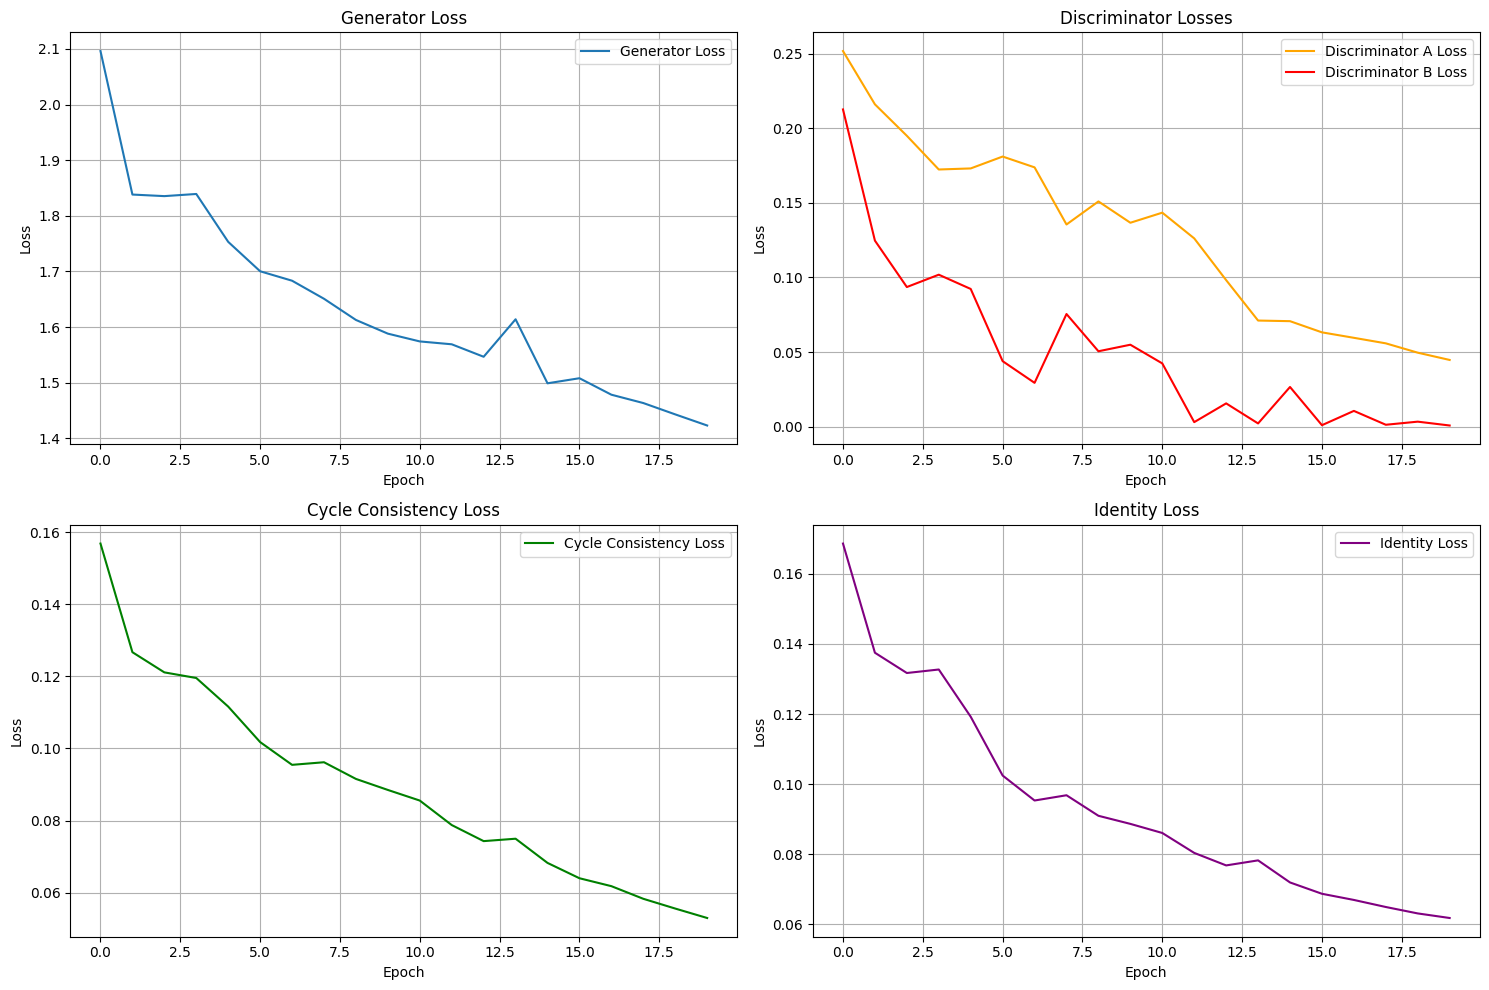

Training history plot saved!


In [19]:
# Execute Training
# Run this cell to start the training process
history = train_cyclegan()

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history['G_loss'], label='Generator Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Generator Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history['D_A_loss'], label='Discriminator A Loss', color='orange')
axes[0, 1].plot(history['D_B_loss'], label='Discriminator B Loss', color='red')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Discriminator Losses')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(history['cycle_loss'], label='Cycle Consistency Loss', color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Cycle Consistency Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(history['identity_loss'], label='Identity Loss', color='purple')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Identity Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(config.sample_dir, 'training_history.png'), dpi=300)
plt.show()

print("Training history plot saved!")

In [ ]:
# Testing and Inference Functions
def test_model(test_image_path, model_type='photo_to_sketch', checkpoint_epoch=None):
    """
    Test the model on a single image
    
    Args:
        test_image_path: Path to test image
        model_type: 'photo_to_sketch' or 'sketch_to_photo'
        checkpoint_epoch: Epoch number to load (None for current model)
    """
    
    # Load checkpoint if specified
    if checkpoint_epoch is not None:
        checkpoint_path = os.path.join(config.checkpoint_dir, f'checkpoint_epoch_{checkpoint_epoch}.pth')
        if os.path.exists(checkpoint_path):
            load_checkpoint(
                checkpoint_path, G_AB, G_BA, D_A, D_B,
                optimizer_G, optimizer_D_A, optimizer_D_B
            )
        else:
            print(f"Warning: Checkpoint not found at {checkpoint_path}")
            print("Using current model weights...")
    
    # Set models to evaluation mode
    G_AB.eval()
    G_BA.eval()
    
    # Load and preprocess image
    image = Image.open(test_image_path).convert('RGB')
    image_tensor = test_transform(image).unsqueeze(0).to(device)
    
    # Generate output
    with torch.no_grad():
        if model_type == 'photo_to_sketch':
            output = G_AB(image_tensor)
            title_input = "Input Photo"
            title_output = "Generated Sketch"
        else:
            output = G_BA(image_tensor)
            title_input = "Input Sketch"
            title_output = "Generated Photo"
    
    # Denormalize for visualization
    input_img = image_tensor.cpu().squeeze().numpy().transpose(1, 2, 0)
    input_img = (input_img * 0.5 + 0.5).clip(0, 1)
    
    output_img = output.cpu().squeeze().numpy().transpose(1, 2, 0)
    output_img = (output_img * 0.5 + 0.5).clip(0, 1)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(input_img)
    axes[0].set_title(title_input, fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(output_img)
    axes[1].set_title(title_output, fontsize=14)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return output_img


def test_batch(test_dir, model_type='photo_to_sketch', checkpoint_epoch=None, num_samples=5):
    """
    Test the model on a batch of images
    
    Args:
        test_dir: Directory containing test images
        model_type: 'photo_to_sketch' or 'sketch_to_photo'
        checkpoint_epoch: Epoch number to load (None for current model)
        num_samples: Number of samples to visualize
    """
    
    # Load checkpoint if specified
    if checkpoint_epoch is not None:
        checkpoint_path = os.path.join(config.checkpoint_dir, f'checkpoint_epoch_{checkpoint_epoch}.pth')
        if os.path.exists(checkpoint_path):
            load_checkpoint(
                checkpoint_path, G_AB, G_BA, D_A, D_B,
                optimizer_G, optimizer_D_A, optimizer_D_B
            )
    
    # Set models to evaluation mode
    G_AB.eval()
    G_BA.eval()
    
    # Get test images
    test_images = sorted(glob.glob(os.path.join(test_dir, '*.*')))[:num_samples]
    
    if len(test_images) == 0:
        print(f"No images found in {test_dir}")
        return
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, img_path in enumerate(test_images):
        # Load and preprocess image
        image = Image.open(img_path).convert('RGB')
        image_tensor = test_transform(image).unsqueeze(0).to(device)
        
        # Generate output
        with torch.no_grad():
            if model_type == 'photo_to_sketch':
                output = G_AB(image_tensor)
            else:
                output = G_BA(image_tensor)
        
        # Denormalize
        input_img = image_tensor.cpu().squeeze().numpy().transpose(1, 2, 0)
        input_img = (input_img * 0.5 + 0.5).clip(0, 1)
        
        output_img = output.cpu().squeeze().numpy().transpose(1, 2, 0)
        output_img = (output_img * 0.5 + 0.5).clip(0, 1)
        
        # Plot
        axes[idx, 0].imshow(input_img)
        axes[idx, 0].set_title('Input', fontsize=12)
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(output_img)
        axes[idx, 1].set_title('Generated', fontsize=12)
        axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.sample_dir, f'test_results_{model_type}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Test results saved to {config.sample_dir}")


def save_best_model(epoch):
    """Save the best model weights separately"""
    checkpoint_path = os.path.join(config.checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
    best_model_path = os.path.join(config.checkpoint_dir, 'best_model.pth')
    
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        torch.save({
            'epoch': checkpoint['epoch'],
            'G_AB_state_dict': checkpoint['G_AB_state_dict'],
            'G_BA_state_dict': checkpoint['G_BA_state_dict'],
        }, best_model_path)
        print(f"Best model saved from epoch {epoch}")
    else:
        print(f"Checkpoint not found for epoch {epoch}")


print("Testing functions defined successfully!")
print("\nUsage examples:")
print("1. Test single image: test_model('path/to/image.jpg', 'photo_to_sketch', checkpoint_epoch=100)")
print("2. Test batch: test_batch('path/to/test_dir', 'photo_to_sketch', checkpoint_epoch=100, num_samples=5)")
print("3. Save best model: save_best_model(100)")

Testing functions defined successfully!

Usage examples:
1. Test single image: test_model('path/to/image.jpg', 'photo_to_sketch', checkpoint_epoch=100)
2. Test batch: test_batch('path/to/test_dir', 'photo_to_sketch', checkpoint_epoch=100, num_samples=5)
3. Save best model: save_best_model(100)


In [7]:
# Model Evaluation and Export for Deployment
def export_models_for_deployment(checkpoint_epoch):
    """
    Export only the generator models for deployment (without optimizers and discriminators)
    This reduces the model size significantly for inference
    
    Args:
        checkpoint_epoch: Epoch number to export
    """
    checkpoint_path = os.path.join(config.checkpoint_dir, f'checkpoint_epoch_{checkpoint_epoch}.pth')
    
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        return
    
    # Load full checkpoint
    checkpoint = torch.load(checkpoint_path)
    
    # Export G_AB (Photo to Sketch)
    g_ab_path = os.path.join(config.checkpoint_dir, f'G_AB_epoch_{checkpoint_epoch}.pth')
    torch.save({
        'epoch': checkpoint['epoch'],
        'model_state_dict': checkpoint['G_AB_state_dict'],
        'config': {
            'img_height': config.img_height,
            'img_width': config.img_width,
            'channels': config.channels
        }
    }, g_ab_path)
    print(f"G_AB (Photo→Sketch) exported to: {g_ab_path}")
    
    # Export G_BA (Sketch to Photo)
    g_ba_path = os.path.join(config.checkpoint_dir, f'G_BA_epoch_{checkpoint_epoch}.pth')
    torch.save({
        'epoch': checkpoint['epoch'],
        'model_state_dict': checkpoint['G_BA_state_dict'],
        'config': {
            'img_height': config.img_height,
            'img_width': config.img_width,
            'channels': config.channels
        }
    }, g_ba_path)
    print(f"G_BA (Sketch→Photo) exported to: {g_ba_path}")
    
    # Check file sizes
    full_size = os.path.getsize(checkpoint_path) / (1024 * 1024)
    g_ab_size = os.path.getsize(g_ab_path) / (1024 * 1024)
    g_ba_size = os.path.getsize(g_ba_path) / (1024 * 1024)
    
    print(f"\nFile sizes:")
    print(f"  Full checkpoint: {full_size:.2f} MB")
    print(f"  G_AB only: {g_ab_size:.2f} MB")
    print(f"  G_BA only: {g_ba_size:.2f} MB")
    print(f"  Space saved: {full_size - g_ab_size - g_ba_size:.2f} MB")


def load_generator_for_inference(model_path, model_type='G_AB'):
    """
    Load a generator model for inference
    
    Args:
        model_path: Path to the exported generator model
        model_type: 'G_AB' or 'G_BA'
    
    Returns:
        Loaded generator model ready for inference
    """
    # Create model
    generator = Generator(input_channels=3, output_channels=3).to(device)
    
    # Load weights
    checkpoint = torch.load(model_path, map_location=device)
    generator.load_state_dict(checkpoint['model_state_dict'])
    generator.eval()
    
    print(f"{model_type} loaded from epoch {checkpoint['epoch']}")
    return generator


def evaluate_model_quality(checkpoint_epoch, num_samples=10):
    """
    Evaluate model quality on test samples
    
    Args:
        checkpoint_epoch: Epoch to evaluate
        num_samples: Number of samples to evaluate
    """
    # Load checkpoint
    checkpoint_path = os.path.join(config.checkpoint_dir, f'checkpoint_epoch_{checkpoint_epoch}.pth')
    if os.path.exists(checkpoint_path):
        load_checkpoint(
            checkpoint_path, G_AB, G_BA, D_A, D_B,
            optimizer_G, optimizer_D_A, optimizer_D_B
        )
    
    G_AB.eval()
    G_BA.eval()
    
    # Get random test samples
    test_loader = DataLoader(
        train_dataset,
        batch_size=1,
        shuffle=True,
        num_workers=0
    )
    
    cycle_errors = []
    
    print(f"\nEvaluating cycle consistency on {num_samples} samples...")
    
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i >= num_samples:
                break
            
            real_A = batch['photo'].to(device)
            real_B = batch['sketch'].to(device)
            
            # Forward cycle: A -> B -> A
            fake_B = G_AB(real_A)
            recov_A = G_BA(fake_B)
            cycle_error_A = torch.mean(torch.abs(recov_A - real_A)).item()
            
            # Backward cycle: B -> A -> B
            fake_A = G_BA(real_B)
            recov_B = G_AB(fake_A)
            cycle_error_B = torch.mean(torch.abs(recov_B - real_B)).item()
            
            cycle_errors.append((cycle_error_A + cycle_error_B) / 2)
    
    avg_cycle_error = np.mean(cycle_errors)
    std_cycle_error = np.std(cycle_errors)
    
    print(f"\nCycle Consistency Metrics:")
    print(f"  Average error: {avg_cycle_error:.6f}")
    print(f"  Std deviation: {std_cycle_error:.6f}")
    print(f"  Min error: {min(cycle_errors):.6f}")
    print(f"  Max error: {max(cycle_errors):.6f}")
    
    return cycle_errors


# GPU Memory Management
def print_gpu_memory():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / 1e9
        reserved = torch.cuda.memory_reserved(0) / 1e9
        print(f"\nGPU Memory:")
        print(f"  Allocated: {allocated:.2f} GB")
        print(f"  Reserved: {reserved:.2f} GB")


def clear_gpu_memory():
    """Clear GPU memory cache"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("GPU memory cache cleared")


print("Evaluation and export functions ready!")
print("\nUsage:")
print("1. Export models: export_models_for_deployment(checkpoint_epoch=100)")
print("2. Evaluate quality: evaluate_model_quality(checkpoint_epoch=100, num_samples=10)")
print("3. Check GPU memory: print_gpu_memory()")
print("4. Clear GPU cache: clear_gpu_memory()")

Evaluation and export functions ready!

Usage:
1. Export models: export_models_for_deployment(checkpoint_epoch=100)
2. Evaluate quality: evaluate_model_quality(checkpoint_epoch=100, num_samples=10)
3. Check GPU memory: print_gpu_memory()
4. Clear GPU cache: clear_gpu_memory()


Testing on random samples from dataset...


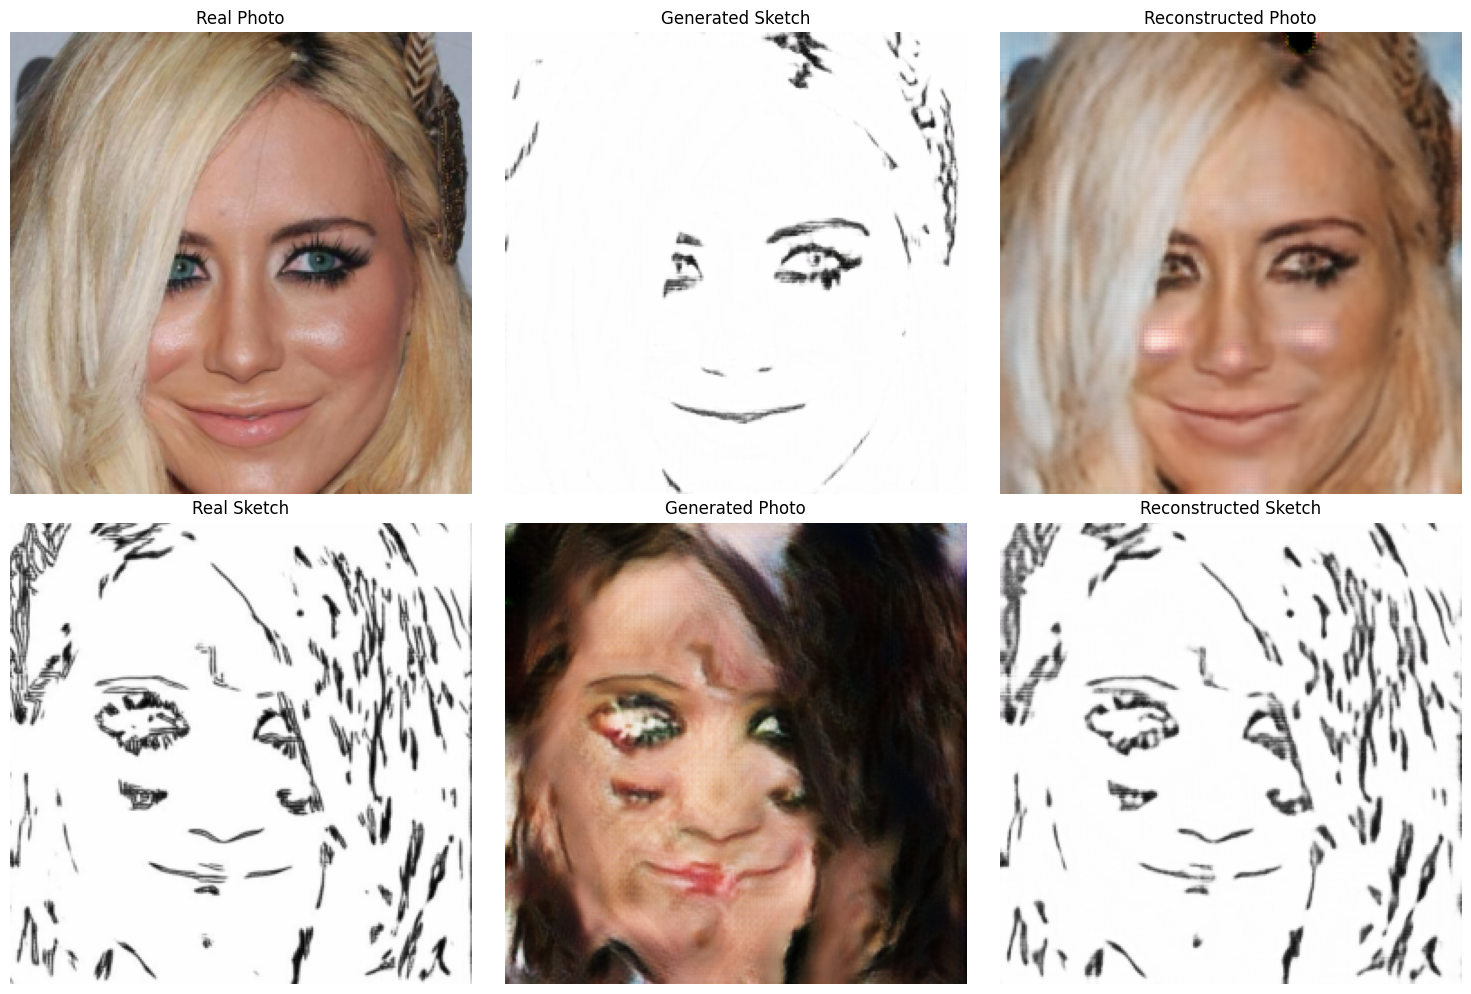

Cycle consistency demonstration saved!

Generating multiple conversions...


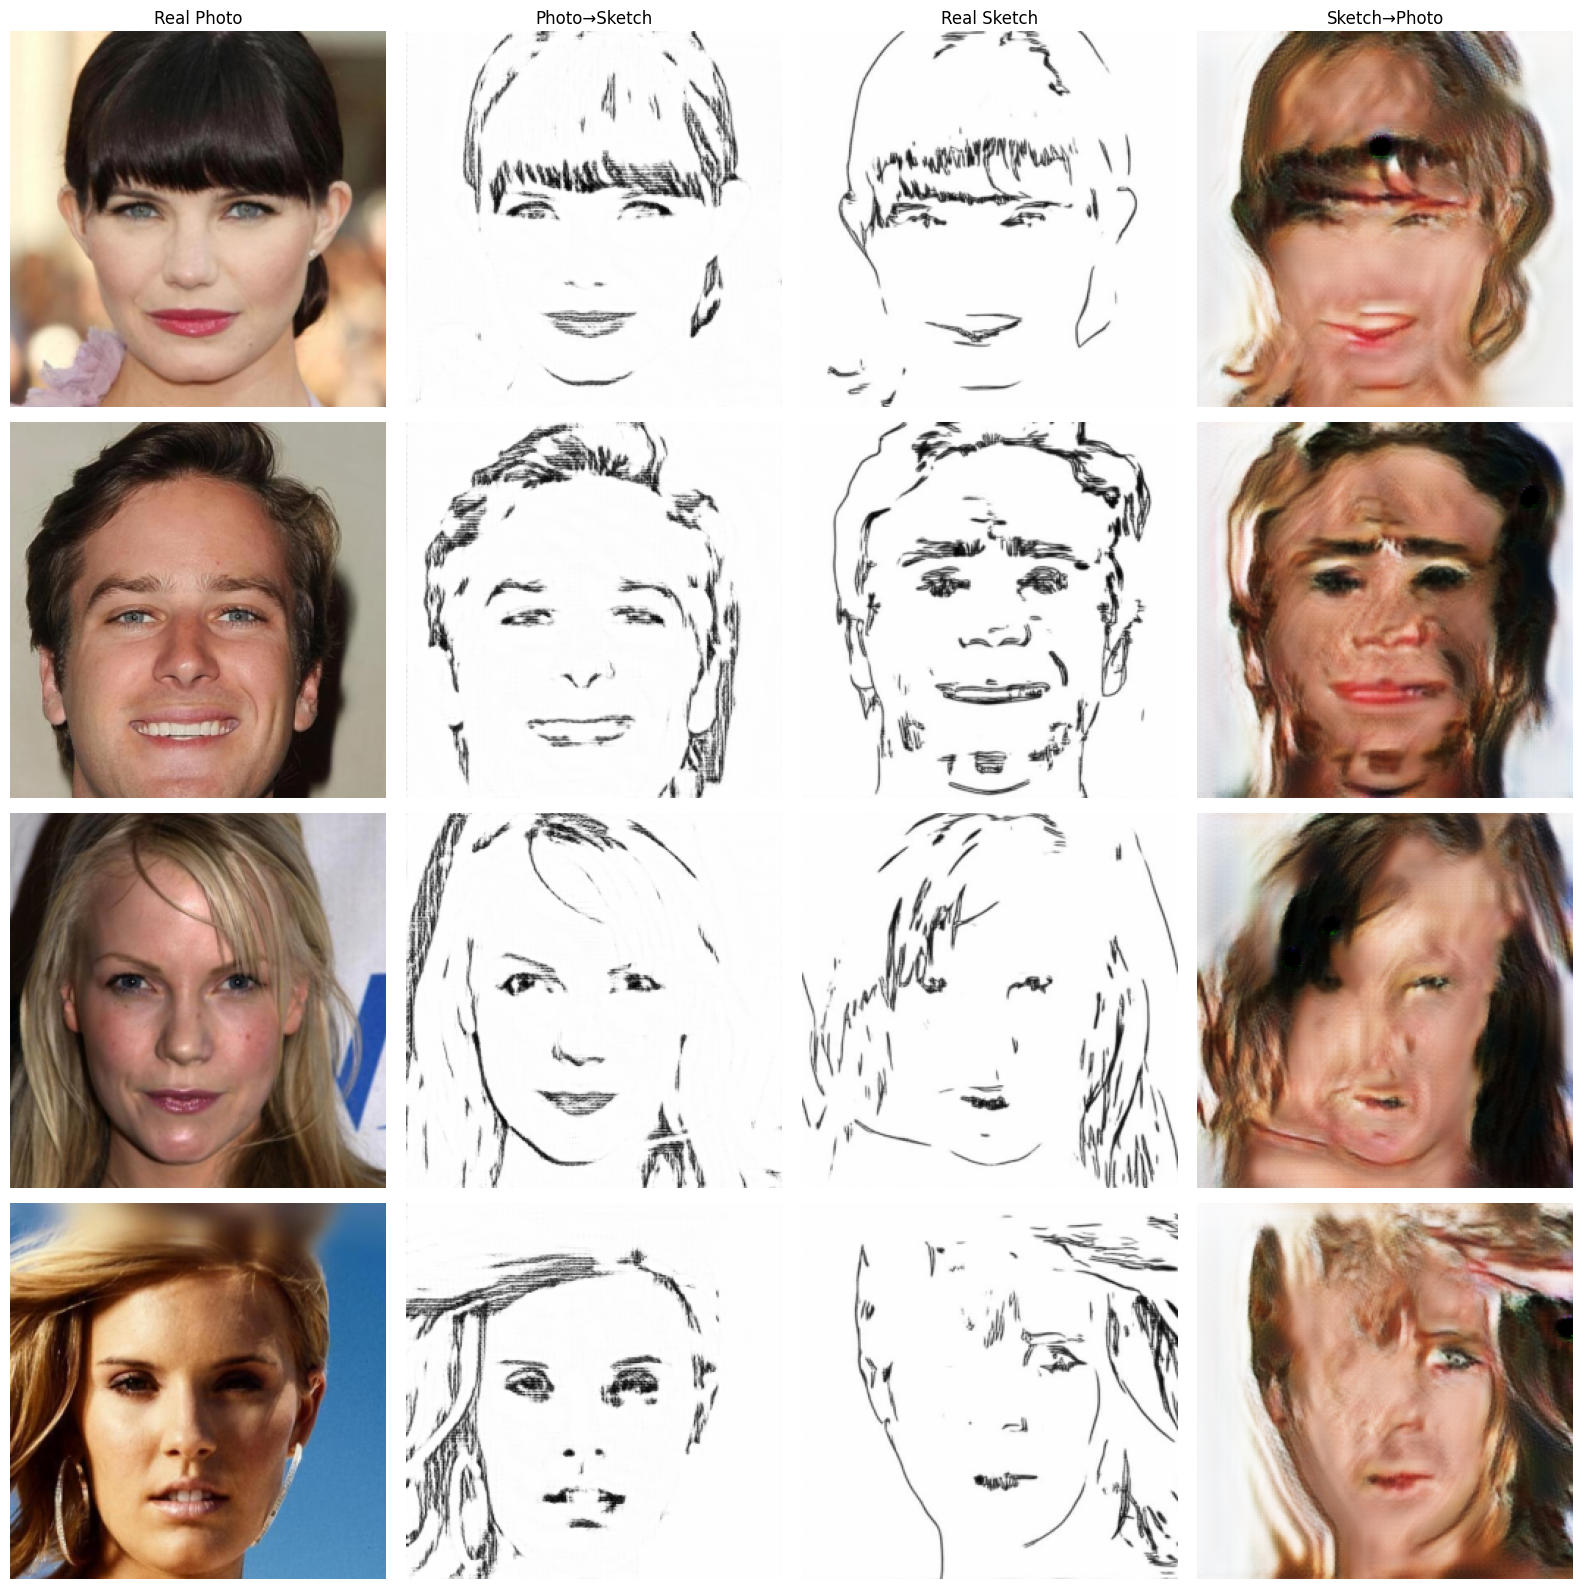

Multiple conversions saved!

All results saved to: samples


In [ ]:
# Quick Test and Visualization Example
# Run this after training to test your model

# Example 1: Test on training samples
print("Testing on random samples from dataset...")
sample_batch = next(iter(train_loader))

G_AB.eval()
G_BA.eval()

with torch.no_grad():
    real_photos = sample_batch['photo'].to(device)
    real_sketches = sample_batch['sketch'].to(device)
    
    # Photo to Sketch to Photo
    fake_sketches = G_AB(real_photos)
    recov_photos = G_BA(fake_sketches)
    
    # Sketch to Photo to Sketch
    fake_photos = G_BA(real_sketches)
    recov_sketches = G_AB(fake_photos)

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Photo -> Sketch -> Photo
img = real_photos[0].cpu().numpy().transpose(1, 2, 0)
axes[0, 0].imshow((img * 0.5 + 0.5).clip(0, 1))
axes[0, 0].set_title('Real Photo', fontsize=12)
axes[0, 0].axis('off')

img = fake_sketches[0].cpu().numpy().transpose(1, 2, 0)
axes[0, 1].imshow((img * 0.5 + 0.5).clip(0, 1))
axes[0, 1].set_title('Generated Sketch', fontsize=12)
axes[0, 1].axis('off')

img = recov_photos[0].cpu().numpy().transpose(1, 2, 0)
axes[0, 2].imshow((img * 0.5 + 0.5).clip(0, 1))
axes[0, 2].set_title('Reconstructed Photo', fontsize=12)
axes[0, 2].axis('off')

# Row 2: Sketch -> Photo -> Sketch
img = real_sketches[0].cpu().numpy().transpose(1, 2, 0)
axes[1, 0].imshow((img * 0.5 + 0.5).clip(0, 1))
axes[1, 0].set_title('Real Sketch', fontsize=12)
axes[1, 0].axis('off')

img = fake_photos[0].cpu().numpy().transpose(1, 2, 0)
axes[1, 1].imshow((img * 0.5 + 0.5).clip(0, 1))
axes[1, 1].set_title('Generated Photo', fontsize=12)
axes[1, 1].axis('off')

img = recov_sketches[0].cpu().numpy().transpose(1, 2, 0)
axes[1, 2].imshow((img * 0.5 + 0.5).clip(0, 1))
axes[1, 2].set_title('Reconstructed Sketch', fontsize=12)
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(config.sample_dir, 'cycle_consistency_demo.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Cycle consistency demonstration saved!")

# Example 2: Show multiple conversions
print("\nGenerating multiple conversions...")
num_samples = 4
sample_indices = random.sample(range(len(train_dataset)), num_samples)

fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))

G_AB.eval()
G_BA.eval()

for idx, sample_idx in enumerate(sample_indices):
    sample = train_dataset[sample_idx]
    
    with torch.no_grad():
        real_photo = sample['photo'].unsqueeze(0).to(device)
        real_sketch = sample['sketch'].unsqueeze(0).to(device)
        
        fake_sketch = G_AB(real_photo)
        fake_photo = G_BA(real_sketch)
    
    # Real photo
    img = real_photo[0].cpu().numpy().transpose(1, 2, 0)
    axes[idx, 0].imshow((img * 0.5 + 0.5).clip(0, 1))
    if idx == 0:
        axes[idx, 0].set_title('Real Photo', fontsize=12)
    axes[idx, 0].axis('off')
    
    # Generated sketch from photo
    img = fake_sketch[0].cpu().numpy().transpose(1, 2, 0)
    axes[idx, 1].imshow((img * 0.5 + 0.5).clip(0, 1))
    if idx == 0:
        axes[idx, 1].set_title('Photo→Sketch', fontsize=12)
    axes[idx, 1].axis('off')
    
    # Real sketch
    img = real_sketch[0].cpu().numpy().transpose(1, 2, 0)
    axes[idx, 2].imshow((img * 0.5 + 0.5).clip(0, 1))
    if idx == 0:
        axes[idx, 2].set_title('Real Sketch', fontsize=12)
    axes[idx, 2].axis('off')
    
    # Generated photo from sketch
    img = fake_photo[0].cpu().numpy().transpose(1, 2, 0)
    axes[idx, 3].imshow((img * 0.5 + 0.5).clip(0, 1))
    if idx == 0:
        axes[idx, 3].set_title('Sketch→Photo', fontsize=12)
    axes[idx, 3].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(config.sample_dir, 'multiple_conversions.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Multiple conversions saved!")
print(f"\nAll results saved to: {config.sample_dir}")

In [8]:
# Cell: Export Lightweight Models for Hugging Face Deployment
# Run this cell AFTER training to prepare models for deployment

def export_for_huggingface(checkpoint_epoch):
    """
    Export only the generator models in a lightweight format for Hugging Face deployment
    This removes all training-related components (discriminators, optimizers)
    
    Args:
        checkpoint_epoch: The epoch number with your best results
    """
    checkpoint_path = os.path.join(config.checkpoint_dir, f'checkpoint_epoch_{checkpoint_epoch}.pth')
    
    if not os.path.exists(checkpoint_path):
        print(f"❌ Checkpoint not found: {checkpoint_path}")
        return
    
    print(f"📦 Loading checkpoint from epoch {checkpoint_epoch}...")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    # Create export directory
    export_dir = 'deployment_models'
    os.makedirs(export_dir, exist_ok=True)
    
    # Export G_AB (Photo → Sketch)
    print("\n🎨 Exporting Photo→Sketch model...")
    g_ab_export = {
        'model_state_dict': checkpoint['G_AB_state_dict'],
        'model_config': {
            'input_channels': 3,
            'output_channels': 3,
            'num_residual_blocks': 9
        },
        'image_config': {
            'img_height': config.img_height,
            'img_width': config.img_width,
            'normalize_mean': [0.5, 0.5, 0.5],
            'normalize_std': [0.5, 0.5, 0.5]
        },
        'training_info': {
            'epoch': checkpoint['epoch'],
            'model_type': 'photo_to_sketch'
        }
    }
    
    g_ab_path = os.path.join(export_dir, 'photo_to_sketch.pth')
    torch.save(g_ab_export, g_ab_path)
    print(f"✅ Saved: {g_ab_path}")
    print(f"   Size: {os.path.getsize(g_ab_path) / (1024*1024):.2f} MB")
    
    # Export G_BA (Sketch → Photo)
    print("\n🖼️  Exporting Sketch→Photo model...")
    g_ba_export = {
        'model_state_dict': checkpoint['G_BA_state_dict'],
        'model_config': {
            'input_channels': 3,
            'output_channels': 3,
            'num_residual_blocks': 9
        },
        'image_config': {
            'img_height': config.img_height,
            'img_width': config.img_width,
            'normalize_mean': [0.5, 0.5, 0.5],
            'normalize_std': [0.5, 0.5, 0.5]
        },
        'training_info': {
            'epoch': checkpoint['epoch'],
            'model_type': 'sketch_to_photo'
        }
    }
    
    g_ba_path = os.path.join(export_dir, 'sketch_to_photo.pth')
    torch.save(g_ba_export, g_ba_path)
    print(f"✅ Saved: {g_ba_path}")
    print(f"   Size: {os.path.getsize(g_ba_path) / (1024*1024):.2f} MB")
    
    # Original checkpoint size
    original_size = os.path.getsize(checkpoint_path) / (1024*1024)
    exported_size = (os.path.getsize(g_ab_path) + os.path.getsize(g_ba_path)) / (1024*1024)
    
    print(f"\n📊 Size Comparison:")
    print(f"   Original checkpoint: {original_size:.2f} MB")
    print(f"   Exported models: {exported_size:.2f} MB")
    print(f"   Space saved: {original_size - exported_size:.2f} MB ({(1 - exported_size/original_size)*100:.1f}% reduction)")
    
    print(f"\n✨ Models ready for deployment!")
    print(f"📁 Location: {export_dir}/")
    print(f"\n📦 Files to upload to Hugging Face:")
    print(f"   1. photo_to_sketch.pth")
    print(f"   2. sketch_to_photo.pth")
    
    return g_ab_path, g_ba_path


# Example: Export your best model
# Replace 100 with your best epoch number
print("="*60)
print("🚀 CYCLEGAN MODEL EXPORT FOR HUGGING FACE DEPLOYMENT")
print("="*60)
print("\nInstructions:")
print("1. Find your best checkpoint epoch (check training history)")
print("2. Run: export_for_huggingface(checkpoint_epoch=YOUR_BEST_EPOCH)")
print("3. Upload the generated .pth files to Hugging Face Spaces")
print("\nExample:")
print(">>> export_for_huggingface(checkpoint_epoch=100)")

export_for_huggingface(checkpoint_epoch=20)

🚀 CYCLEGAN MODEL EXPORT FOR HUGGING FACE DEPLOYMENT

Instructions:
1. Find your best checkpoint epoch (check training history)
2. Run: export_for_huggingface(checkpoint_epoch=YOUR_BEST_EPOCH)
3. Upload the generated .pth files to Hugging Face Spaces

Example:
>>> export_for_huggingface(checkpoint_epoch=100)
📦 Loading checkpoint from epoch 20...

🎨 Exporting Photo→Sketch model...
✅ Saved: deployment_models\photo_to_sketch.pth
   Size: 43.42 MB

🖼️  Exporting Sketch→Photo model...
✅ Saved: deployment_models\sketch_to_photo.pth
   Size: 43.42 MB

📊 Size Comparison:
   Original checkpoint: 323.85 MB
   Exported models: 86.85 MB
   Space saved: 237.00 MB (73.2% reduction)

✨ Models ready for deployment!
📁 Location: deployment_models/

📦 Files to upload to Hugging Face:
   1. photo_to_sketch.pth
   2. sketch_to_photo.pth


('deployment_models\\photo_to_sketch.pth',
 'deployment_models\\sketch_to_photo.pth')